# Advanced usage of HiPS and MOCs
## Exploring large catalogs within non-trivial spatial coverage, defined by brightness cuts and/or the availability of additional data sets
Originally by 

**Caroline Bot and Thomas Boch, CDS**

as published on http://www.euro-vo.org/?q=science/scientific-tutorials
converted to jupyter notebook by 

**Katharina Lutz, Thomas Boch, Matthieu Baumann, CDS**

This tutorial was first presented at "Detecting the unexpected, Discovery in the Era of Astronomically Big Data" Space Telsecope Science Instite, February 27 - March 2, 2017. It was updated to Aladin v10 in June 2017 and to Gaia DR2 in June 2018. 

This is a hands-on tutorial demonstrating an advanced useage of Hierarchical Progressive Suerveys (HiPS) and Multi-Order Coverage (MOC) maps in Aladin. Using this tutorial you will learn to handle a problem like: 
>"I have a set of images, I would like to select regions in my observations that are above a given threshold in another survey (e.g. at low extinction), retrieve objects from very large catalogues (e.g. Gaia + WISE) in these non-trivial shapes and not-necessarily-connected regions and combine them to visualise some quantities (e.g. colour-colour diagram). "

## Before we get started
The original tutorial was using Aladin (https://aladin.u-strasbg.fr/) and TOPCAT (http://www.star.bris.ac.uk/~mbt/topcat/), in this version of the tutorial we will use python packages and Aladin to accomplish the same tasks. The python packages include MOCpy (https://github.com/cds-astro/mocpy), astroquery (https://astroquery.readthedocs.io/en/latest/), pyVO (https://pyvo.readthedocs.io/en/latest/), ipyaladin (https://github.com/cds-astro/ipyaladin) as well as astropy and matplotlib. 

Now let's go!

In [1]:
import warnings 
import glob
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky
import astropy.wcs as astropy_wcs
import astropy.units as u
import mocpy
import pyvo
import healpy as hp
import cdshealpix
from astroquery.vizier import Vizier

warnings.filterwarnings('ignore')

## Find all Short-Red images associated to the MASH catalog using the VizieR associated data service
The VizieR service at CDS allows you to look for astronomical catalogues that have been published in the literature. Among these catalogues, some contain data associated to the publications and the tables therein. These data can be browsed and explored through the VizieR associated data service, which is linked to the traditional VizieR table service. In the current example we are looking for images associated with the MASH catalogue of planetary nebulae (Parker et al 2006-2008). The MASH fits files are cut-outs extracted from a larger H$\alpha$ and Short Red survey and can be best described as a set of regions of interstes around planetary nebulae. 

To find VizieR associated data, we use the Table Access Protocol (TAP) with the VizieR endpoint. Through the VizieR TAP endpoint we can search for tables, content of tables and for information on associated data. 

First we search for the MASH catalogue:

In [2]:
tap_vizier = pyvo.dal.TAPService('http://tapvizier.u-strasbg.fr/TAPVizieR/tap')

query = '''
SELECT  *  FROM tables 
WHERE description LIKE '%MASH%Parker%'
'''

mash_catalogues = tap_vizier.search(query).to_table()
mash_catalogues

schema_name,table_name,table_type,description,utype
object,bytes36,object,object,object
viz7,V/127A/mash2,table,"The MASH-II Supplement (from paper II) ( Parker Q.A., Acker A., Frew D.J., Hartley M., Peyaud A.E.J., Phillipps S., Russeil D., Beaulieu S.F., Cohen M., Koppen J., Marcout J., Miszalski B., Morgan D.H., Morris R.A.H., Ochsenbein F., Pierce M.J.,)",
vizB,J/MNRAS/412/223/table4,table,"The nine MASH PNe detected and possibly detected in the PMN survey ( Bojicic I.S., Parker Q.A., Filipovic M.D., Frew D.J.)",
vizB,J/MNRAS/412/223/mpgs2,table,"MASH PNe detected in the MPGS-2 (Cat. VIII/82) ( Bojicic I.S., Parker Q.A., Filipovic M.D., Frew D.J.)",
vizB,J/MNRAS/412/223/table1,table,"MASH PNe detected in the NVSS ( Bojicic I.S., Parker Q.A., Filipovic M.D., Frew D.J.)",
viz7,V/127A/mash1,table,"The MASH Catalog of Planetary Nebulae (paper I) ( Parker Q.A., Acker A., Frew D.J., Hartley M., Peyaud A.E.J., Phillipps S., Russeil D., Beaulieu S.F., Cohen M., Koppen J., Marcout J., Miszalski B., Morgan D.H., Morris R.A.H., Ochsenbein F., Pierce M.J.,)",


For this tutorial, we are interested in the tables belonging to the catalogues `V/127A`, this includes tables `V/127A/mash1` and `V/127A/mash2`. To have a look at the content of these tables we do the following:

In [ ]:
query = '''
SELECT TOP 5 * FROM \"V/127A/mash1\" 
'''
mash1_head = tap_vizier.search(query).to_table()
mash1_head

As you can see, the last column of this table is called `AssocData` and contains the entry `fits`. If you look at this table on the VizieR web interface, you can download the associated fits file. Within this notebook, we query the `obscor` database to get the URLs to the fits file. Using the `astropy.io.fits` module, we can then open the fits files from their URLs.

In [4]:
obs_tap_vizier = pyvo.dal.TAPService('http://cdsarc.u-strasbg.fr/saadavizier.tap/tap')
query = """
SELECT TOP 5  *  FROM obscore 
WHERE obs_collection='V/127A'
"""
mash_fits = obs_tap_vizier.search(query).to_table()
# mash_fits = tap_vizier.search(query).to_table()
mash_fits

dataproduct_type,calib_level,obs_id,obs_collection,obs_publisher_did,target_name,s_ra,s_dec,s_fov,s_region,s_resolution,t_min,t_max,t_exptime,t_resolution,em_min,em_max,em_band,o_ucd,pol_states,facility_name,instrument_name,access_url,access_format,access_estsize,has_wcs,extension
,,,,,,deg,deg,,,,d,d,,,,,,,,,,,,,,
object,int32,object,object,object,object,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,int64,int32,int32
image,-1,1028_ha.fits,V/127A,ivo://CDS.VizieR/V/127A?res=1028_ha.fits,,110.9506689873,0.61323523573,0.0663457244774261,Polygon ICRS 110.91750198367993 0.6464079953496699 110.91750239168711 0.5800622738294424 110.98383557963164 0.5800622708722438 110.98383599389436 0.6464079920542088,0.948698895605968,51910.0,--,--,--,3e-07,1e-06,Optical,obs.image,NotSet,UKST,SuperCOSMOS I,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864972848244981761,application/fits,725760,1,0
image,-1,1002_sr.fits,V/127A,ivo://CDS.VizieR/V/127A?res=1002_sr.fits,,98.3541075805,-18.13981460846,0.0663567511486386,Polygon ICRS 98.31921087035784 -18.1066330873718 98.31919776270303 -18.172989967668318 98.38901753365111 -18.17298983852044 98.38900415464332 -18.106632958728472,0.948831003995876,51160.0,--,--,--,3e-07,1e-06,Optical,obs.image,NotSet,UKST,SuperCOSMOS I,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864972848244981762,application/fits,581760,1,0
image,-1,1027_sr.fits,V/127A,ivo://CDS.VizieR/V/127A?res=1027_sr.fits,,110.6277469954,-13.09174409106,0.0663571477857845,Polygon ICRS 110.59369027898428 -13.058563283378934 110.59368117168717 -13.124920496124918 110.66181288551986 -13.124920431164716 110.66180364517486 -13.058563218758842,0.948939377323562,51226.0,--,--,--,3e-07,1e-06,Optical,obs.image,NotSet,UKST,SuperCOSMOS I,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864972848244981763,application/fits,610560,1,0
image,-1,1058_sr.fits,V/127A,ivo://CDS.VizieR/V/127A?res=1058_sr.fits,,122.1291633759,-35.0779308305,0.0663623445466155,Polygon ICRS 122.0886435993402 -35.044742914040924 122.08861096513894 -35.111105534018456 122.16971612262338 -35.11110525858754 122.1696828159762 -35.044742639287485,0.948943690726311,51582.0,--,--,--,3e-07,1e-06,Optical,obs.image,NotSet,UKST,SuperCOSMOS I,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864972848244981764,application/fits,627840,1,0
image,-1,1003_ha.fits,V/127A,ivo://CDS.VizieR/V/127A?res=1003_ha.fits,,98.289085649,-1.58678076262,0.0663493202104687,Polygon ICRS 98.25590500816867 -1.5536058364101442 98.25590395459673 -1.6199551676068031 98.32226735396317 -1.619955156620613 98.32226627885831 -1.5536058258741463,0.948775381926423,51904.0,--,--,--,3e-07,1e-06,Optical,obs.image,NotSet,UKST,SuperCOSMOS I,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864972848244981765,application/fits,714240,1,0


As you can see, the result from this query proivides us with information of the fits files, which are associated with the MASH catalogues. In particular the column `access_url` provides us with the location of the data. To get the first image we could do:

`image = fits.open(mash_fits['access_url'][0])`

and then work on the image, plot it or save it to our machine. However downloading all the data and working with all the data, takes quite some time. So, for the purpose of this tutorial, **we prepared a subsample of 335 of these Short Red images that will run in a timely manner** but we encourage you to repeat with the full Short Red sample later. **The subsample is available at 
http://astro.u-strasbg.fr/~bot/BochBot.tar.gz** and in the Data Folder of this repository. So if you run this tutorial on Binder, you do not need to download anything. 

## Create a MOC of the MASH images
The multi-order coverage (MOC) map of a set of images is a useful represation of the sky coverage of these images. MOCs can represent arbitrary patches on the sky, which do not need to be connected. The union or intersection of two MOCs can be calculated quickly and with small computational effort. Catalogues can be filterd by MOCs. 

Here we can create the MOC of the MASH images with the `MOCPy` module. Please note that the majority of the following cell is concerned with removing keywords from the fits file headers, which would otherwise hamper the MOC creation (because the underlying `astropy.wcs.WCS` module is confused by these additional DEPRECATED header keywords):

In [5]:
# Get a list of all fits files 
mash_file_list = glob.glob('Data/MASH_Sample/*.fits')
# If this cell block was run before, there are too many files in the 
# folder, so before we do anything, we clean up.
for file_name in mash_file_list:
    if '_mod' in file_name:
        os.remove(file_name)
mash_file_list = glob.glob('Data/MASH_Sample/*.fits')
# Modify the header so that the MOC creation works smoothly
for file_name in mash_file_list:
    ima = fits.open(file_name)
    removeable_keywords = ['PC001001', 'PC001002',
                           'PC002001', 'PC002002','XPIXELSZ',
                           'YPIXELSZ']
    for keyword in removeable_keywords:
        try:
            del ima[0].header[keyword]
        except KeyError:
            continue
    ima.writeto(file_name.split('.fits')[0] + '_mod.fits', overwrite=True)
    ima.close()
# Get a list of the updated files and create the MOC    
mash_file_list = glob.glob('Data/MASH_Sample/*_mod.fits')
moc_mash = mocpy.MOC.from_fits_images(mash_file_list, max_norder=15)
moc_mash.write('Data/mash_moc.fits', overwrite=True)

Data/MASH_Sample/2001_sr.fits
Data/MASH_Sample/2254_sr.fits
Data/MASH_Sample/2043_sr.fits
Data/MASH_Sample/2264_sr.fits
Data/MASH_Sample/2249_sr.fits
Data/MASH_Sample/2245_sr.fits
Data/MASH_Sample/2109_sr.fits
Data/MASH_Sample/2165_sr.fits
Data/MASH_Sample/2309_sr.fits
Data/MASH_Sample/2324_sr.fits
Data/MASH_Sample/2150_sr.fits
Data/MASH_Sample/2040_sr.fits
Data/MASH_Sample/2193_sr.fits
Data/MASH_Sample/2135_sr.fits
Data/MASH_Sample/2323_sr.fits
Data/MASH_Sample/2332_sr.fits
Data/MASH_Sample/2128_sr.fits
Data/MASH_Sample/2153_sr.fits
Data/MASH_Sample/2061_sr.fits
Data/MASH_Sample/2131_sr.fits
Data/MASH_Sample/2098_sr.fits
Data/MASH_Sample/2060_sr.fits
Data/MASH_Sample/2151_sr.fits
Data/MASH_Sample/2312_sr.fits
Data/MASH_Sample/2204_sr.fits
Data/MASH_Sample/2020_sr.fits
Data/MASH_Sample/2311_sr.fits
Data/MASH_Sample/2076_sr.fits
Data/MASH_Sample/2277_sr.fits
Data/MASH_Sample/2064_sr.fits
Data/MASH_Sample/2156_sr.fits
Data/MASH_Sample/2054_sr.fits
Data/MASH_Sample/2005_sr.fits
Data/MASH_

Data/MASH_Sample/2052_sr.fits
Data/MASH_Sample/2050_sr.fits
Data/MASH_Sample/2078_sr.fits
Data/MASH_Sample/2021_sr.fits
Data/MASH_Sample/2173_sr.fits
Data/MASH_Sample/2224_sr.fits
Data/MASH_Sample/2028_sr.fits
Data/MASH_Sample/2303_sr.fits
Data/MASH_Sample/2207_sr.fits
Data/MASH_Sample/2163_sr.fits
Data/MASH_Sample/2126_sr.fits
Data/MASH_Sample/2118_sr.fits
Data/MASH_Sample/2239_sr.fits
Data/MASH_Sample/2087_sr.fits
Data/MASH_Sample/2251_sr.fits
Data/MASH_Sample/2106_sr.fits
Data/MASH_Sample/2295_sr.fits
Data/MASH_Sample/2133_sr.fits
Data/MASH_Sample/2036_sr.fits
Data/MASH_Sample/2102_sr.fits
Data/MASH_Sample/2072_sr.fits
Data/MASH_Sample/2186_sr.fits
Data/MASH_Sample/2179_sr.fits
Data/MASH_Sample/2033_sr.fits
Data/MASH_Sample/2294_sr.fits
Data/MASH_Sample/2284_sr.fits
Data/MASH_Sample/2140_sr.fits
Data/MASH_Sample/2120_sr.fits
Data/MASH_Sample/2027_sr.fits
Data/MASH_Sample/2011_sr.fits
Data/MASH_Sample/2099_sr.fits
Data/MASH_Sample/2116_sr.fits
Data/MASH_Sample/2279_sr.fits
Data/MASH_

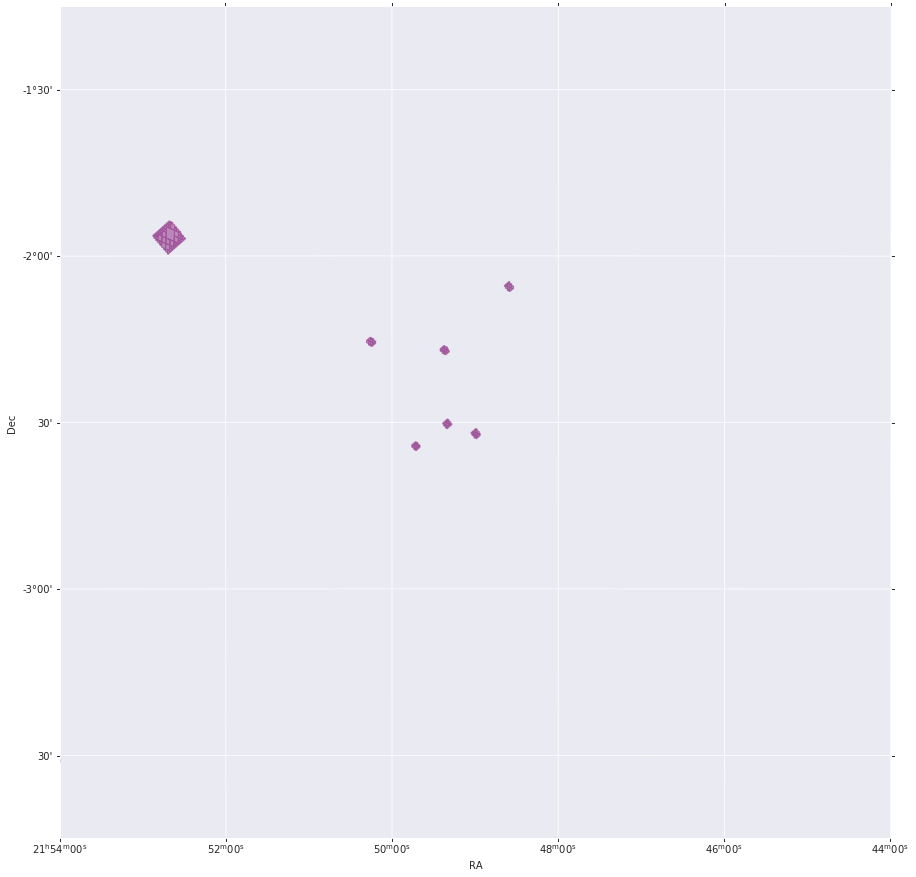

In [6]:
fig_centre = SkyCoord('21:49:00', '-02:30:00', 
                      unit=(u.hourangle, u.deg), frame='galactic')

sns.set_style('darkgrid')
fig = plt.figure(figsize=(15, 15))
with mocpy.World2ScreenMPL(fig, fov=2.5 * u.deg,
                           center=fig_centre,
                           coordsys="galactic", 
                           rotation=Angle(0, u.degree),
                           projection="AIT") as wcs:
    ax = fig.add_axes([0.17, 0.17, 0.77, 0.77], projection=wcs)
    moc_mash.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color=mpl.cm.magma(0.4))
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    lon, lat = ax.coords[0], ax.coords[1]
    lon.set_major_formatter('hh:mm:ss')
    lat.set_major_formatter('dd:mm')
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)

This figure only shows a small region on the Sky, but you can see how the MOC has arbitrary shapes and not all regions are connected. 

## Load an archival extinction map and create the MOC of the low extinction regions
Different works (e.g. Schlegel et al. 1998, Schlafly  & Finkbeiner 2011, Green et al. 2015 or Dobashi et al. 2013) have created extinction maps of the sky and these maps are publicly available. Some of these maps are all-sky maps, other have higher resolutions, or come from different methods... Such maps are available in healpix format (among others) on the LAMBDA website or the CADE website. For the purpose of this tutorial, we will download the well known all-sky extinction map from Schlegel et al. from the LAMBDA website, and define as a MOC the low extinction area for which 0<E(B-V)<0.4. 
The map is available from here: https://lambda.gsfc.nasa.gov/data/foregrounds/SFD/lambda_sfd_ebv.fits and we save it to disc. 

In [7]:
ext_map = fits.open('https://lambda.gsfc.nasa.gov/data/foregrounds/SFD/' + 
                    'lambda_sfd_ebv.fits')
ext_map.writeto('Data/Schlegel_extinction_map.fits', overwrite=True)
ext_map.close()

We are only interested in regions with low extinction. So our aim is to get a MOC of all regions, where the extinction values from the Schlegel et al. map are in the range from 0 to 0.5mag. The extinction map we got from the NASA webpage is in the Healpix format, which is a very useful and efficient presentation of all-sky maps. The Healpix tesselation is also used by the MOCs. So to get the MOC from the extinction map, we do the following. First we change the projection of the map and set the order (i.e. resolution) of the map, so that the resulting MOC will have the right shape:

In [9]:
# Read the map
ext_map = hp.read_map('Data/Schlegel_extinction_map.fits', nest=False)
# define the coordinate transformation
r = hp.Rotator(coord=['G','C'])
# do the coordinate and representation transformation
ext_map_equatorial_ring = r.rotate_map_pixel(ext_map)
ext_map_equatorial = hp.reorder(ext_map_equatorial_ring, r2n=True)
# set the resolution
nside = 512
norder = hp.nside2order(nside)

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/home/lutz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='Data/Schlegel_extinction_map.fits' mode='rb' closefd=True>
  


Next we declare which pixel we want to use, i.e. all pixels with low extinction:

In [ ]:
indexes_pixels_to_keep = np.where((ext_map_equatorial<0.5) & 
                                  (ext_map_equatorial>0.0))[0]

Since we brought the extinction map in the right shape, the indexes of the pixels that we want to keep are the indexes of the Healpix cells we are interested in. Thus the MOC is created by:

In [ ]:
moc_low_ext = mocpy.MOC.from_healpix_cells(indexes_pixels_to_keep, 
                                           np.full((len(indexes_pixels_to_keep,)), 
                                                    norder))

In [ ]:
moc_low_ext.write('Data/low_extinction_moc.fits', overwrite=True)

## Step 5:  Find out which regions are covered by the MASH short red images and in the low extinction regions defined above

To find out which regions of the sky are covered by the MASH sample and which are at low extinction, we build the intersection of the two MOCs.

In [ ]:
moc_intersection = moc_low_ext.intersection(moc_mash)
moc_intersection.sky_fraction

Now we can visualise the coverage of the two MOCs and their intersection. The grey area is where the extinction is low, the blue area is the MASH coverage and the red area is the MASH coverage in low extinction regions. 

In [ ]:
fig = plt.figure(111, figsize=(10, 8))
with mocpy.World2ScreenMPL(fig, fov=200 * u.deg,
                           center=SkyCoord(200, -20, unit='deg', frame='icrs'),
                           coordsys="icrs",
                           rotation=Angle(0, u.degree),
                           projection="AIT") as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs)
    moc_low_ext.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="grey")
    moc_mash.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="dodgerblue")
    moc_intersection.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="crimson")
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    lon, lat = ax.coords[0], ax.coords[1]
    lon.set_major_formatter('hh:mm:ss')
    lat.set_major_formatter('dd:mm')
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)
    lon.set_ticks(spacing=2 * u.hourangle)
plt.grid(color="black", linestyle="dotted")

## Step 6: Query the 2MASS and Gaia Catalogue by MOC
Without the usage of MOC, querying for sources in the low extinction regions covered by the MASH subsample would be tedious or even impossible. Indeed, one would need to load the whole catalog and make selections which would not be possible given the size of some catalogues. Alternatively, one would need to query the catalogue field by field, which would take time and several queries. Instead, here, we will use the power of MOC files to query large catalogs directly in the covered regions only. We will use the coverage of the low extinction and MASH-covered region to query for sources from the Gaia and WISE surveys, in this highly non-continuous and non-trivial shape areas.

First let's see which Gaia and 2MASS catalogues are available on VizieR. We could as above use the TAP endpoint of VizieR or we use as shown below the `Vizier` module in the `astroquery` package. 

In [ ]:
catalog_list_twomass = Vizier.find_catalogs('Cutri')
for k, v in catalog_list_twomass.items():
    print(k, ': ', v.description)

In [ ]:
catalog_list_gaia = Vizier.find_catalogs('Gaia DR2')
for k, v in catalog_list_gaia.items():
    print(k, ': ', v.description)

For 2MASS we will want to use `II/246 :  2MASS All-Sky Catalog of Point Sources (Cutri+ 2003)` and for Gaia `I/345 :  Gaia DR2 (Gaia Collaboration, 2018)`. Before we actually query the two table we just get a few sources for each of the tables to understand, which columns are available ect. The query below will give us 50 sources each as is the default for the `get_catalogs` method.

In [ ]:
test_twomass = Vizier.get_catalogs('II/246')
print(test_twomass)
test_twomass[0]

In [ ]:
test_gaia = Vizier.get_catalogs('I/345')
print(test_gaia)
test_gaia[0]

As you will see below, we only need coordinates, 2MASS photometry in the H and K band, and Gaia photometry in the Gaia G band. So we'll query the tables `II/246/out` for 2MASS and `I/345/gaia2` for Gaia DR2:

In [ ]:
twomass = moc_intersection.query_vizier_table('II/246/out', max_rows=20000)
twomass

In [ ]:
gaia = moc_intersection.query_vizier_table('I/345/gaia2', max_rows=20000)
gaia

## Step 7: Cross-match Gaia and WISE sources in all fields
We now want to find sources in the selected region (observed in the MASH regions of interests and at low extinction) that are common to the WISE and Gaia catalogues. To do so, we will perform a cross-match of the Gaia and the WISE catalogues. Alternatively, we could also use the CDS XMatch service via the corresponding `astroquery` module.

In [ ]:
twomass_coord = SkyCoord(ra=twomass['RAJ2000'], dec=twomass['DEJ2000'], unit=u.deg)
gaia_coord = SkyCoord(ra=gaia['ra_epoch2000'], 
                      dec=gaia['dec_epoch2000'], unit=u.deg)
idx, d2d, d3d = match_coordinates_sky(twomass_coord, gaia_coord)

In [ ]:
max_sep = 1.0 * u.arcsec
sep_constraint = d2d < max_sep
twomass_matches = twomass[sep_constraint]
gaia_matches = gaia[idx[sep_constraint]]
match_cat = twomass_matches['_2MASS', 'RAJ2000', 'DEJ2000', 'Hmag', 'Kmag']
match_cat['Gmag'] = gaia_matches['phot_g_mean_mag']
match_cat

## Step 8: Build a colour-colour diagram

We now use the data we got from the cross-match to get a WISE/Gaia colour-colour diagram for all the soruces in the sky regions that is covered by the MASH survey and at low extinction:

In [ ]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10.0, 8.0))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot(match_cat['Hmag'] - match_cat['Kmag'], 
        match_cat['Gmag'] - match_cat['Hmag'], linestyle='', marker='.')
ax.set_xlabel('H - Ks [mag]')
ax.set_ylabel('G - H [mag]')